# Rotevol tracing — RRRG

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyrotevol

In [2]:
# read history values

from pyrotevol.io import gather_rotevol_inputs

df, rotevol_inputs = gather_rotevol_inputs('LOGS_1099')

  0%|          | 0/2590 [00:00<?, ?it/s]

In [3]:
# get age of best-fitting model

from astropy import units as u, constants as c

i_best = np.where(df.model_number.values == 2646)[0][0]
best_age = float(df.star_age[df.model_number == 2646]) * u.yr

In [4]:
# What is the breakup speed?

Ωcrit = np.sqrt(c.G * df.star_mass.values * u.M_sun / (np.power(10, df.log_R.values) * u.R_sun)**3).cgs
Pcrit = (2 * np.pi / Ωcrit).to(u.d)

Pcrit

<Quantity [ 0.12760962,  0.1277437 ,  0.12791953, ..., 29.65145889,
           29.66462268, 29.67774794] d>

In [5]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm, SymLogNorm
from mesa_tricks.plots import ColorBarHelper
def colorline(x, y, c, norm=None, **kwargs):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    if norm is None:
        norm = plt.Normalize(c.min(), c.max())
    lc = LineCollection(segments, norm=norm, **kwargs)
    lc.set_array(c)
    line = plt.gca().add_collection(lc)
    return line

0.2476259356897186 100.00000000023758
5.084708972402781e-33 99.99999999993311
5.084708972402781e-33 99.99999999993723
3126732.8926296234


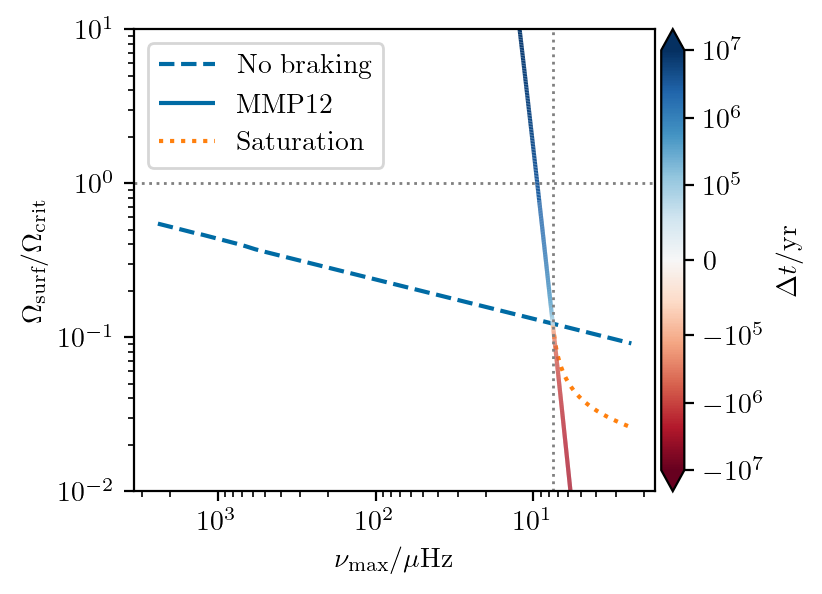

In [7]:
plt.style.use('tableau-colorblind10')

from pyrotevol import RotEvol
from astropy import units as u, constants as c
from scipy.optimize import bisect

# Store the retrodictions somewhere

retrodictions = {}
Δt = 4e9 # look this far back in time
scenarios = [None, 'unsaturated', 'MMP12']
ω0 = 3.394e-5
ωcrits = {None: ω0, 'MMP12': 1.9e-5, 'unsaturated': 1e-20}

# Simple functions are better

rotevol = {_: RotEvol(braking=_) for _ in [None, 'PMM12']}
def run_single(braking, Pdisk, Δt, ωcrit):
    res = rotevol[braking].run_single(
        f_k=9.367677149667827 / (ωcrit/ω0)**2, Pdisk=Pdisk*u.d,
        Tlock=best_age.to(u.Myr)/1.000000001 - Δt*u.yr,
        ωcrit=float(ωcrit),
        **rotevol_inputs
    )
    return res

# Actually run rotevol calculations

for s in scenarios:
    braking = None if s is None else 'PMM12'
    ωcrit = ωcrits[s] if s in ωcrits else s

    def discrepancy(log_Pdisk):
        Pdisk = np.power(10, log_Pdisk)
        res = run_single(braking, Pdisk, Δt, ωcrit)
        return res['Prot'][i_best] - 100

    try:
        log_Pdisk = bisect(discrepancy, -60, 2)
        Pdisk = np.power(10, log_Pdisk)
        res = run_single(braking, Pdisk, Δt, ωcrit)
        print(Pdisk, res['Prot'][i_best])
    except Exception as e:
        print(e)
        continue

    retrodictions[s] = res

for s in scenarios:
    res = retrodictions[s]
    Q = res['Prot']
    m = df.star_age < (best_age.value - Δt)
    if s == 'MMP12':
        m = df.star_age < (best_age.value)
    if s not in ['MMP12', None]:
        δt = -(df.star_age.values - best_age.value)
        cbar = ColorBarHelper(δt, 'RdBu')
        line = colorline(df.nu_max[~m], Pcrit[~m]/Q[~m],
                         label='MMP12',
                         c=δt[~m], cmap='RdBu',# norm=cbar.norm)
                         norm=SymLogNorm(vmin=-1e7, vmax=1e7, linthresh=1e5))
        print(δt[np.argmin((1 - Pcrit/Q/u.d)**2)])
    else:
        plt.plot(df.nu_max[~m], Pcrit[~m]/Q[~m], label='Saturation' if s else 'No braking',
                 ls='dotted' if s else 'dashed', zorder=-10 if s else None)
    
plt.colorbar(line, pad=.01, label=r"$\Delta t$/yr", extend='both')
plt.axvline(df.nu_max.values[i_best], ls='dotted', c='gray', lw=1)
plt.axhline(1, ls='dotted', c='gray', lw=1)
plt.gca().set_yscale('log')
plt.ylim(1e-2, 1e1)
plt.gca().set_xscale('log')

plt.legend()

plt.gca().invert_xaxis()
plt.gcf().set_size_inches(4,3)

plt.xlabel(r"$\nu_\text{max}/\mu$Hz")
plt.ylabel(r"$\Omega_\text{surf}/\Omega_\text{crit}$")
plt.savefig("braking.pdf", bbox_inches='tight', transparent=False)
plt.show()

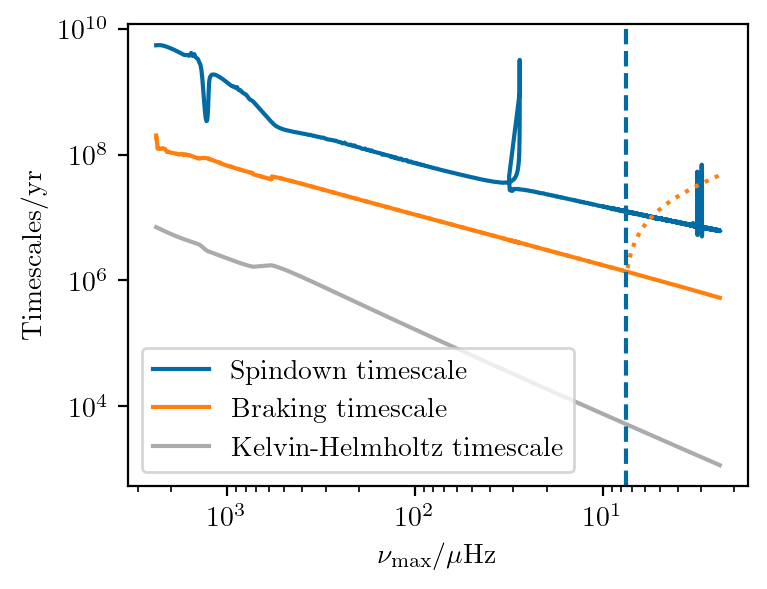

In [8]:
for s in retrodictions:
    res = retrodictions[s]
    if s is None:
        Q = res['Prot']
    else:
        Q = res['Jtot']
    m = (df.star_age > (best_age.value - Δt)) & np.array([True, *(np.diff(df.log_L) > 0)])
    δt = df.star_age.values - best_age.value
    plt.plot(df.nu_max[m], np.abs(Q[m]/np.gradient(Q[m], df.star_age[m])),
             label={None: 'Spindown timescale', 'unsaturated': r"Braking timescale",
                    'MMP12': None}.get(s, s),
             c="C1" if s == 'unsaturated' else None,
             ls="dotted" if s == 'MMP12' else None,
            )

t_KH = (c.G * (df.star_mass.values * u.M_sun)**2 / (2 * np.power(10, df.log_L.values) * u.L_sun * np.power(10, df.log_R.values) * u.R_sun)).to(u.yr)
plt.plot(df.nu_max[m], t_KH[m], label=r"Kelvin-Helmholtz timescale")
plt.axvline(df.nu_max.values[i_best], ls='dashed')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

plt.legend(loc='lower left')

plt.gca().invert_xaxis()

plt.xlabel(r"$\nu_\text{max}/\mu$Hz")
plt.ylabel(r"Timescales/yr")
plt.gcf().set_size_inches(4,3)
plt.savefig("timescales.pdf", bbox_inches='tight', transparent=False)
plt.show()

In [ ]:
from mesa_tricks.io import read_gyre
def for_alex(model):
    info, gyre = read_gyre(f"LOGS_1099/profile{model}.data.GYRE")
    gyre[['r', 'ρ']].to_csv(f"for_alex/density_{model}.csv", index=False)
    
for model in df.profile.values[::10]:
    for_alex(model)

In [ ]:
M = df.star_mass.values[0] * u.M_sun
new_df = pd.DataFrame({'profile': df.profile.values,
                       'star_age': df.star_age.values,
                       'log_L': df.log_L.values,
                       'effective_T': df.effective_T.values,
                       'star_mass': df.star_mass.values,
                       'm_cz': (M - rotevol_inputs['m_cz']).to(u.g).value,
                       'R': rotevol_inputs['R'].to(u.cm).value,
                       'r_cz': rotevol_inputs['r_cz'].to(u.cm).value,
                      })
new_df.to_csv("for_alex.csv", index=False)